In [20]:
from apps.onedimensional.shallowwatermomentequations import shallow_water_moment_equations
from apps.onedimensional.shallowwatermomentequations.manufacturedsolutionexample import manufactured_solution_example
from pydogpack import main
from pydogpack.tests.utils import utils
from pydogpack.timestepping import explicit_runge_kutta
from pydogpack.utils import dg_utils
from pydogpack.utils import math_utils
from pydogpack.utils import x_functions
from pydogpack.utils import xt_functions
from pydogpack.visualize import plot

import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10]

from IPython.display import HTML

# Manufactured Solution

In [21]:
num_moments = 3

gravity_constant = 1.0
kinematic_viscosity = 0.0
slip_length = 0.0

q1 = xt_functions.AdvectingSine(0.1, 1.0, 1.0, 0.0, 1.0)
q2 = xt_functions.AdvectingSine(0.1, 1.0, 0.0, 0.1, 1.0)
q3 = xt_functions.AdvectingSine(0.1, 1.0, 0.0, 0.2, 1.0)
q4 = xt_functions.AdvectingSine(0.1, 1.0, 0.0, 0.3, 1.0)
q5 = xt_functions.AdvectingSine(0.1, 1.0, 0.0, 0.4, 1.0)
function_list = [q1, q2, q3, q4, q5]
exact_solution = xt_functions.ComposedVector(function_list[:(num_moments + 2)])
max_wavespeed = 0.1 + np.sqrt(gravity_constant * 1.1 + 0.1 * 0.1)

problem = manufactured_solution_example.ManufacturedSolutionExample(
    exact_solution, 
    max_wavespeed, 
    num_moments, 
    gravity_constant, 
    kinematic_viscosity, 
    slip_length
)

time_final = 0.75
problem.parameters["time_final"] = time_final
problem.parameters["is_weak"] = True

space_time_order = 1
problem.parameters["time_stepping"]["time_stepping_class"] = "explicit_runge_kutta"
problem.parameters["time_stepping"]["is_verbose"] = False
problem.parameters["time_stepping"]["num_frames"] = 10
problem.parameters["time_stepping"]["order"] = space_time_order

num_elems = 20
x_left = 0.0
x_right = 1.0
problem.parameters["mesh"]["mesh_class"] = "mesh_1d_uniform"
problem.parameters["mesh"]["x_left"] = x_left
problem.parameters["mesh"]["x_right"] = x_right
problem.parameters["mesh"]["num_elems"] = num_elems

problem.parameters["basis"]["basis_class"] = "legendre"
problem.parameters["basis"]["inner_product_constant"] = 0.5
problem.parameters["basis"]["num_basis_cpts"] = space_time_order

problem.parameters["boundary_condition"]["boundary_condition_class"] = "periodic"
problem.parameters["riemann_solver"]["riemann_solver_class"] = "local_lax_friedrichs"

cfl = explicit_runge_kutta.get_cfl(space_time_order)
#cfl = 0.5
delta_x = (x_right - x_left) / num_elems
delta_t = float(dg_utils.get_delta_t(cfl, problem.max_wavespeed, delta_x))
#delta_t = 0.075
problem.parameters["delta_t"] = delta_t

problem._setup_objects()

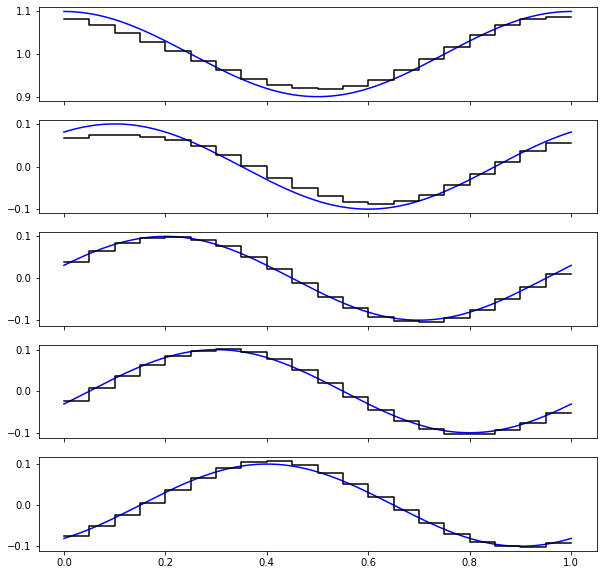

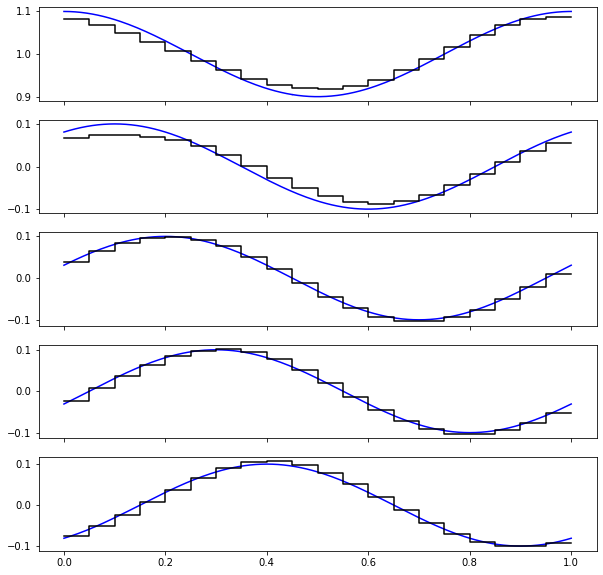

In [22]:
final_solution = main.run(problem)
exact_final_solution = x_functions.FrozenT(problem.exact_solution, time_final)
p = plot.create_plot_dg_1d(final_solution, exact_final_solution)
ani, fig = plot.create_animation_output_dir(problem.output_dir, problem.exact_solution)
HTML(ani.to_html5_video())

In [14]:
delta_t

0.03900949262530666

## Convergence Test

In [6]:
wavespeed = 1.0
num_moments = 2

gravity_constant = 1.0
kinematic_viscosity = 0.0
slip_length = 0.0

q1 = xt_functions.AdvectingSine(0.1, 1.0, 1.0, 0.0, wavespeed)
q2 = xt_functions.AdvectingSine(0.1, 1.0, 0.0, 0.1, wavespeed)
q3 = xt_functions.AdvectingSine(0.1, 1.0, 0.0, 0.2, wavespeed)
q4 = xt_functions.AdvectingSine(0.1, 1.0, 0.0, 0.3, wavespeed)
q5 = xt_functions.AdvectingSine(0.1, 1.0, 0.0, 0.4, wavespeed)
list_ = [q1, q2, q3, q4, q5]
exact_solution = xt_functions.ComposedVector(list_[:(num_moments+2)])
max_wavespeed = 0.1 + np.sqrt(gravity_constant * 1.1 + 0.1 * 0.1)

problem = manufactured_solution_example.ManufacturedSolutionExample(
    exact_solution, 
    max_wavespeed, 
    num_moments, 
    gravity_constant, 
    kinematic_viscosity, 
    slip_length
)

time_final = 0.75
exact_final_solution = x_functions.FrozenT(problem.exact_solution, time_final)
problem.parameters["time_final"] = time_final
problem.parameters["is_weak"] = True

problem.parameters["time_stepping"]["time_stepping_class"] = "explicit_runge_kutta"
problem.parameters["time_stepping"]["is_verbose"] = False
problem.parameters["time_stepping"]["num_frames"] = 10

x_left = 0.0
x_right = 1.0
problem.parameters["mesh"]["mesh_class"] = "mesh_1d_uniform"
problem.parameters["mesh"]["x_left"] = x_left
problem.parameters["mesh"]["x_right"] = x_right

problem.parameters["basis"]["basis_class"] = "legendre"
problem.parameters["basis"]["inner_product_constant"] = 0.5

problem.parameters["boundary_condition"]["boundary_condition_class"] = "periodic"
problem.parameters["riemann_solver"]["riemann_solver_class"] = "local_lax_friedrichs"

In [7]:
for num_basis_cpts in range(1, 2):
    problem.parameters["basis"]["num_basis_cpts"] = num_basis_cpts
    problem.parameters["time_stepping"]["order"] = num_basis_cpts
    
    cfl = explicit_runge_kutta.get_cfl(num_basis_cpts)
    error_list = []
    for num_elems in [20, 40]:
        delta_x = (x_right - x_left) / num_elems
        delta_t = float(dg_utils.get_delta_t(cfl, problem.max_wavespeed, delta_x))
        problem.parameters["delta_t"] = delta_t
        problem.parameters["mesh"]["num_elems"] = num_elems
        
        problem._setup_objects()
        final_solution = main.run(problem)
        
        error = math_utils.compute_error(final_solution, exact_final_solution)
        error_list.append(error)
    order = utils.convergence_order(error_list)
    print(order)
    print(error_list)
    if error_list[-1] >= math_utils.MACHINE_ERROR:
        assert order >= num_basis_cpts

1.0
[0.27935403202238956, 0.1441448244033097]
